<a href="https://colab.research.google.com/github/mardzien/machine_learning/blob/main/nlp_disaster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import os
import random
from random import randint

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

In [2]:
# input data
data_path = "drive/MyDrive/Kaggle/nlp-getting-started"

In [3]:
train_path = os.path.join(data_path, "train.csv")
test_path = os.path.join(data_path, "test.csv")
sample_submission_path = os.path.join(data_path, "sample_submission.csv")

In [4]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
# I want to build and test model first
# Maybe later i will try to join kaggle competition
df = train_df[['text', 'target']]

In [7]:
# let's check if classes are balanced
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# let's vizualiza some random tweets and see how can I clean them

def show_random_tweets(df=df, text_col="text", label_col="target", n=10):
  for _ in range(n):
    rand_index = randint(0, len(df))
    print(f"""Tweet: {df[text_col].iloc[rand_index]}
Label: {df[label_col].iloc[rand_index]}
--------------------------""")

In [9]:
show_random_tweets()

Tweet: @eggalie haha I love hurricane because of you
Label: 0
--------------------------
Tweet: Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!
Label: 0
--------------------------
Tweet: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: .: RT DrAyesha4: #IndiaKoMunTorJawabDo

Indian Army kiÛ_ http://t.co/WJLJq3yA4g
Label: 0
--------------------------
Tweet: beforeitsnews : Hundreds feared dead after Libyan migrant boat capsizes during rescue Û_ http://t.co/MjoeeBDLXn) http://t.co/fvEn1ex0PS
Label: 1
--------------------------
Tweet: Russian 'food crematoria' provoke outrage amid crisis famine memories: MOSCOW (Reuters) - Russian government ... http://t.co/Mphog0QDDN
Label: 1
--------------------------
Tweet: @YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha
Label: 0
--------------------------
Tweet: @lauren_miller_7 she won't harm you
Label: 0
--------------------------

In [10]:
show_random_tweets(n=20)

Tweet: #TweetLikeItsSeptember11th2001 Those two buildings are on fire
Label: 1
--------------------------
Tweet: Demco 8550013 Hijacker 5th Wheel Hitch 21K Ultra Series Double Pivot http://t.co/hRdwGfbFYq http://t.co/nUOhKmPZFj
Label: 0
--------------------------
Tweet: County 911 Overload Prompts Use of Emergency Plan During July 4 Celebrations http://t.co/HXTUPrA5bc http://t.co/DqxKJibbKy
Label: 0
--------------------------
Tweet: First Responders Convene for National Summit and Awards on GIS Technology http://t.co/0T9yd557rY #gisuserPR #geoTech
Label: 0
--------------------------
Tweet: @KatieKatCubs you already know how this shit goes. World Series or Armageddon.
Label: 0
--------------------------
Tweet: BHAVANA'S MOM HAS CRUSHED EVERYONE'S SOUL
Label: 0
--------------------------
Tweet: Now that's what you call a batting collapse #theashes
Label: 1
--------------------------
Tweet: Madhya Pradesh Train Derailment: Village Youth Saved Many Lives
Label: 1
--------------------------

# basic cleaning will embrace:
- Lowering all characters
- Removing punctuation
- Removing stopwords
- lemmetization or steming (optionally)
- removing URLs
- removing usernames (starts with @ symbol)
- I'm not sute what to do with #. It looks like topics, somtimes in short form. Safe approach is to remove just # symbol and treat topic jaki any other word
- maybe some further improvments


In [11]:
# lets see if i can lemmatize tex in g collab using spacy
import spacy

In [12]:
spacy.__version__

'3.6.1'

In [13]:
# loading basic english model
nlp = spacy.load("en_core_web_sm")

In [14]:
def lemmatize_text(input_text, nlp=nlp):
  doc = nlp(input_text)
  lemmatized_text = " ".join(token.lemma_ for token in doc)
  return lemmatized_text

In [15]:
# let's pick come random tweet and lemmatize it

random_tweet = df['text'].iloc[randint(0, len(df))]

In [16]:
random_tweet

'Blending the old with the new in #Vanuatu to prepare for future emergencies: \nhttp://t.co/aFMKcFn1TL http://t.co/8QqzYZIAqf'

In [17]:
lemmatized_random_tweet = lemmatize_text(random_tweet)
lemmatized_random_tweet

'blend the old with the new in # Vanuatu to prepare for future emergency : \n http://t.co/aFMKcFn1TL http://t.co/8qqzyziaqf'

In [18]:
# I can remove stopwords and punctuation using spacy and lemmatizing text in one function

In [19]:
def spacy_clean(input_text, nlp=nlp):
  doc = nlp(input_text)
  result = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num])
  return result

In [20]:
spacy_preprocessed_tweet = spacy_clean(random_tweet)
spacy_preprocessed_tweet

'blend old new Vanuatu prepare future emergency \n http://t.co/aFMKcFn1TL http://t.co/8qqzyziaqf'

In [21]:
def preprocess_test(input_text):
  result = input_text.replace('#', '').lower()
  result = re.sub(r'http\S+', '', result)
  result = re.sub(r'@\w+', '', result)
  return result.strip()

In [22]:
def clean_text(input_text, nlp=nlp):
  result = preprocess_test(input_text)
  result = spacy_clean(result, nlp)
  return result

In [23]:
random_tweet = df['text'].iloc[randint(0, len(df))]
random_tweet

'\x89ÛÏ@dylanmcclure55: Working at zumiez is the http://t.co/zW5jp46v5k\x89Û\x9d which location??'

In [24]:
cleaned_tweet = clean_text(random_tweet)
cleaned_tweet

'\x89ûï work zumiez   location'

In [25]:
# lets apply combined functions to text column and create simplified one

In [26]:
df['cleaned_text'] = df['text'].apply(clean_text)

<ipython-input-26-85fe8bd99969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = df['text'].apply(clean_text)


In [27]:
df

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control w...,1,control wild fire california northern state tr...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 01:04 utc]?5 km s volcano hawaii
7611,Police investigating after an e-bike collided ...,1,police investigate e bike collide car little p...


In [28]:
# df seems to be structured, let's shuffle it

shuffled_df = df.sample(frac=1, random_state=42)
shuffled_df = shuffled_df.sample(frac=1, random_state=42)
# picking only simplified tweets, and renaming cols
shuffled_df = shuffled_df[['cleaned_text', 'target']]
shuffled_df.columns = ['text', 'label']

In [29]:
shuffled_df

,text,label
4955,dfr ep016 monthly meltdown dnbheaven drum ba...,0
584,fedex long transport bioterror germ wake anthr...,0
7411,gunman kill el salvador bus attack suspect sal...,1
5950,internally externally scream,1
5541,radiation emergency preparedness start know in...,1
...,...,...
7090,upheaval create west iraq syria libya etc,1
629,win &amp think possibility transformation impo...,0
6464,near sand half sink shattered visage lie,1
6265,kesabaran membuahkan hasil indah pada saat tep...,1


Looks like not everything is perfect, but it looks good enough for text vectorization

In [30]:
# We don't have any labels in test_set
# Let's split train set into train and validation sets

train_texts, test_texts, train_labels, test_labels = train_test_split(
    shuffled_df["text"].to_numpy(),
    shuffled_df["label"].to_numpy(),
    test_size=0.1,
    random_state=42
    )

In [31]:
# now its time to make text vectorizer, I need to define max_token number
# lets, check what is average number of tokens in train set

In [32]:
sum([len(text.split()) for text in train_texts]) / len(train_texts)

8.248576850094876

In [33]:
# max number of tokens
max([len(text.split()) for text in train_texts])

21

In [34]:
max_vocab_length = 10_000 # max number of words to have in our vocabulary
max_length = 10 # max length sequences will be, so longer tweets will be cut off

In [35]:
vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [36]:
vectorizer.adapt(train_texts)

In [37]:
# choose a random sentence from training dataset and tokenize it

random_sentence = random.choice(train_texts)
print(f"Text in original form: {random_sentence}")

random_sentence_tokenized = vectorizer([random_sentence])
print(f"Text in tokenized form: {random_sentence_tokenized}")

Text in original form: stem cub talk- team roster cancer survivor   amp fan help
Text in tokenized form: [[3577    1  376  446 3709 1085  246    4  240   74]]


In [38]:
# let's see whats the most and the least popular words in vocab
words_in_vocab = vectorizer.get_vocabulary() # get all teh unique words in vocab

print(f"""
Number of words in vocab: {len(words_in_vocab)}
10 most common words are: {words_in_vocab[:10]}
10 least common words are: {words_in_vocab[-10:]}

""")


Number of words in vocab: 10000
10 most common words are: ['', '[UNK]', 'like', 'fire', 'amp', 'new', 'go', 'people', 'news', 'video']
10 least common words are: ['drumpf', 'drummond', 'drown\x89û', 'droughtmonitor', 'droughtcheck', 'droppd', 'drob', 'drjustinmazur', 'driving\x89û\x9d', 'driverlesscar']




In [39]:
# I set token limit for 10_000 and remaining tokens that dinc't fit into vocab were marked as UNK token
# now ist time to make embeddings from vectorized text

In [40]:
embedding = Embedding(
    input_dim=max_vocab_length,
    output_dim=256, # number of dims in embedding
    input_length=max_length,
)

In [41]:
random_sentence = random.choice(train_texts)
print(f"Text in original form: {random_sentence}")

random_sentence_tokenized = vectorizer([random_sentence])
print(f"Text vectorized: {random_sentence_tokenized}")

random_sentence_embedding = embedding(random_sentence_tokenized)
print(f"Text embedding: {random_sentence_embedding}")

Text in original form: meltdown day
Text vectorized: [[454  20   0   0   0   0   0   0   0   0]]
Text embedding: [[[ 0.00196254  0.03171334  0.03859912 ...  0.04823488 -0.02019898
    0.02932071]
  [-0.0037928   0.04920104 -0.03150735 ...  0.01343484  0.02398324
   -0.04497401]
  [ 0.00540693  0.00755706 -0.04322105 ...  0.00540217  0.01142382
    0.01160406]
  ...
  [ 0.00540693  0.00755706 -0.04322105 ...  0.00540217  0.01142382
    0.01160406]
  [ 0.00540693  0.00755706 -0.04322105 ...  0.00540217  0.01142382
    0.01160406]
  [ 0.00540693  0.00755706 -0.04322105 ...  0.00540217  0.01142382
    0.01160406]]]


In [42]:
random_sentence_embedding.shape

TensorShape([1, 10, 256])

In [43]:
# create tokenization and modelling pipeline
base_model = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to number
    ("clf", MultinomialNB()) # model the text
])

In [44]:
base_model.fit(train_texts, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [45]:
base_model.score(train_texts, train_labels)

0.8949058531601226

In [46]:
base_preds = base_model.predict(test_texts)

In [47]:
# lets see base_preds vs actual labels

In [48]:
base_preds[:10]

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [49]:
test_labels[:10]

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [50]:
# results are looking good!
# its good idea to create some function so I can see basic metrics for diffrent models

In [51]:
def get_model_metrics(pred_y, actual_y=test_labels):

  accuracy = accuracy_score(pred_y, actual_y)
  precision, recall, f1, _ = precision_recall_fscore_support(
      pred_y, actual_y, average="weighted"
      )
  d = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
  }

  return d

In [52]:
basic_metrics = get_model_metrics(base_preds)
basic_metrics

{'accuracy': 0.7926509186351706,
 'precision': 0.8164176665170986,
 'recall': 0.7926509186351706,
 'f1': 0.7974916826740289}

In [53]:
# ok now I have first results I can refer to in deep learning
# lets build some basic model using tensorflow

model_1 = Sequential()

model_1.add(layers.Input(shape=(1,), dtype=tf.string))
model_1.add(vectorizer)
model_1.add(layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=256,
    input_length=max_length,
))
model_1.add(layers.LSTM(units=128))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    )

In [54]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 10)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 10, 256)           2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2757249 (10.52 MB)
Trainable params: 2757249 (10.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
model_1_history = model_1.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 24s 92ms/step - loss: 0.4926 - accuracy: 0.7635 - val_loss: 0.4620 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 18s 82ms/step - loss: 0.2923 - accuracy: 0.8863 - val_loss: 0.4864 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 21s 100ms/step - loss: 0.1937 - accuracy: 0.9272 - val_loss: 0.5963 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 25s 117ms/step - loss: 0.1374 - accuracy: 0.9511 - val_loss: 0.6185 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 26s 120ms/step - loss: 0.0959 - accuracy: 0.9645 - val_loss: 0.8349 - val_accuracy: 0.7703


In [56]:
# looks like model is overfitting, lets see model's history on plot

<Axes: >

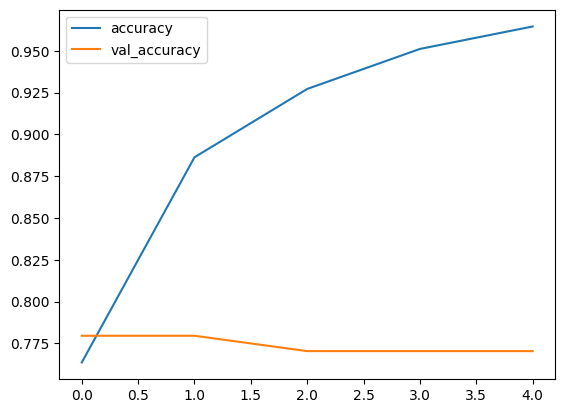

In [57]:
history_1_df = pd.DataFrame(model_1_history.history)[['accuracy', 'val_accuracy']]
history_1_df.plot()

In [58]:
# lets see how model_1 predictions looks like
model_1_predictions = model_1.predict(test_texts)
model_1_predictions[:10]

24/24 [==============================] - 1s 21ms/step


array([[0.13276902],
       [0.00327851],
       [0.9248503 ],
       [0.999988  ],
       [0.39529702],
       [0.34818053],
       [0.00455232],
       [0.23222159],
       [0.7300761 ],
       [0.72157717]], dtype=float32)

In [59]:
model_1_predictions.shape

(762, 1)

In [60]:
# sigmoid functions returns probability instead of predicted label
# also probas needs reshaping
# let's write function to convert propabilitier to predicted labels

def calculate_preds(model, test_data=test_texts):
  probas = model.predict(test_data)
  labels = tf.squeeze(tf.round(probas))
  return labels

In [61]:
model_1_predictions = calculate_preds(model_1)
model_1_predictions[:10]

24/24 [==============================] - 1s 21ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 1., 0., 0., 0., 0., 1., 1.], dtype=float32)>

In [62]:
model_1_metrics = get_model_metrics(model_1_predictions)
model_1_metrics

{'accuracy': 0.7703412073490814,
 'precision': 0.7876127809456549,
 'recall': 0.7703412073490814,
 'f1': 0.7743810548180997}

In [63]:
model_2 = Sequential()

model_2.add(layers.Input(shape=(1,), dtype=tf.string))
model_2.add(vectorizer)
model_2.add(layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=256,
    input_length=max_length,
))
model_2.add(layers.LSTM(units=64, dropout=0.4, recurrent_dropout=0.4))
model_2.add(layers.Dense(16, activation='relu', kernel_regularizer='l2'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
    )

In [64]:
model_2_history = model_2.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 35s 110ms/step - loss: 0.9121 - accuracy: 0.5776 - val_loss: 0.8717 - val_accuracy: 0.5906
Epoch 2/5
215/215 [==============================] - 25s 114ms/step - loss: 0.8270 - accuracy: 0.6643 - val_loss: 0.7613 - val_accuracy: 0.7231
Epoch 3/5
215/215 [==============================] - 29s 133ms/step - loss: 0.6598 - accuracy: 0.8139 - val_loss: 0.6447 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 23s 109ms/step - loss: 0.5350 - accuracy: 0.8520 - val_loss: 0.6244 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 25s 117ms/step - loss: 0.4566 - accuracy: 0.8826 - val_loss: 0.6238 - val_accuracy: 0.7808


<Axes: >

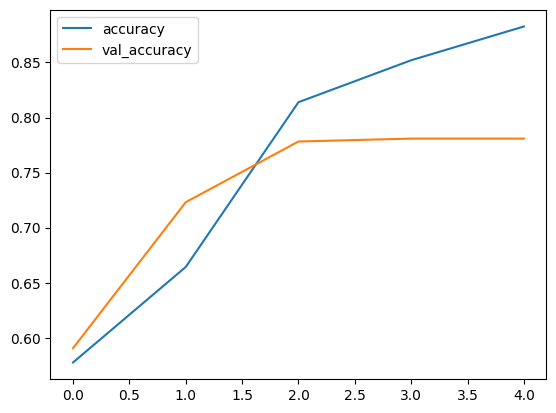

In [65]:
history_2_df = pd.DataFrame(model_2_history.history)[['accuracy', 'val_accuracy']]
history_2_df.plot()

In [66]:
# arrucacy curver looks much better, but despite of many regularization
# model is still overfitting in 5 epochs and results are worse than base model

In [67]:
# lets try universal sentence encoder from tensorflow hub - the most downloaded model from embedding section

# use example from tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [68]:
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype="string",
    name="USE"
)

In [69]:
model_3 = Sequential()

model_3.add(use_layer)
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dropout(0.4))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

In [70]:
model_3_history = model_3.fit(
    x=train_texts,
    y=train_labels,
    epochs=5,
    validation_data=(test_texts, test_labels)
)

Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.5367 - accuracy: 0.7589 - val_loss: 0.4471 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4463 - accuracy: 0.7946 - val_loss: 0.4298 - val_accuracy: 0.8163
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4293 - accuracy: 0.8063 - val_loss: 0.4303 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.4226 - accuracy: 0.8101 - val_loss: 0.4276 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4130 - accuracy: 0.8168 - val_loss: 0.4287 - val_accuracy: 0.8123


In [71]:
# ok, results are better and the most important thing is that model is not overfitting
# lets implemment early stopping, and increase epochs

In [72]:
model_4 = tf.keras.Sequential()

model_4.add(use_layer)
model_4.add(tf.keras.layers.Dense(64, activation='relu'))
model_4.add(tf.keras.layers.Dropout(0.5))
model_4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [73]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )

In [74]:
model_4_history = model_4.fit(
    x=train_texts,
    y=train_labels,
    epochs=100,
    validation_data=(test_texts, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
215/215 [==============================] - 16s 51ms/step - loss: 0.5470 - accuracy: 0.7573 - val_loss: 0.4550 - val_accuracy: 0.8084
Epoch 2/100
215/215 [==============================] - 4s 20ms/step - loss: 0.4552 - accuracy: 0.7942 - val_loss: 0.4366 - val_accuracy: 0.8110
Epoch 3/100
215/215 [==============================] - 11s 53ms/step - loss: 0.4376 - accuracy: 0.8034 - val_loss: 0.4328 - val_accuracy: 0.8176
Epoch 4/100
215/215 [==============================] - 12s 57ms/step - loss: 0.4301 - accuracy: 0.8075 - val_loss: 0.4312 - val_accuracy: 0.8097
Epoch 5/100
215/215 [==============================] - 6s 29ms/step - loss: 0.4215 - accuracy: 0.8154 - val_loss: 0.4323 - val_accuracy: 0.8176
Epoch 6/100
215/215 [==============================] - 13s 59ms/step - loss: 0.4140 - accuracy: 0.8165 - val_loss: 0.4308 - val_accuracy: 0.8110
Epoch 7/100
215/215 [==============================] - 5s 25ms/step - loss: 0.4063 - accuracy: 0.8208 - val_loss: 0.4319 - val_accur

In [75]:
model_4_preds = calculate_preds(model_4)

24/24 [==============================] - 1s 11ms/step


In [76]:
model_4_results = get_model_metrics(model_4_preds)

In [77]:
model_4_results

{'accuracy': 0.8162729658792651,
 'precision': 0.8226590799871495,
 'recall': 0.8162729658792651,
 'f1': 0.8178317396695821}

In [78]:
basic_metrics

{'accuracy': 0.7926509186351706,
 'precision': 0.8164176665170986,
 'recall': 0.7926509186351706,
 'f1': 0.7974916826740289}

Results from model 4 are quite good considering that dataset is rather small and tweets are written in short, informal language. Also the line between determining whether something is a description of a disaster or not is very thin and depends on context (retweets, comments e.t.c)

Let's use model_4 for kaggle competition and create file in proper format for submission.

In [79]:
sample_submission_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [80]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [81]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [82]:
test_texts = test_df['cleaned_text'].to_numpy()

In [83]:
test_preds = calculate_preds(model_4, test_data=test_texts)

102/102 [==============================] - 2s 19ms/step


In [84]:
test_preds

<tf.Tensor: shape=(3263,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 1., 0.], dtype=float32)>

In [85]:
submission_df = pd.DataFrame(zip(test_df.id, np.array(test_preds)), columns=['id', 'target'])

In [86]:
submission_df = submission_df.astype({'target': int})

In [87]:
submission_df

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [88]:
submission_df.to_csv("submission.csv", index=False)